In [18]:
import random
import pandas as pd
import math
import matplotlib.pyplot as plt

Загрузить данные

In [19]:
def load_data():
  df = pd.read_csv("city.csv")
  citynames = df["city"].tolist()
  lat = df["lat"].tolist()
  lng = df["lng"].tolist()
  return citynames, list(zip(lat, lng))

citynames, points = load_data()
n_cities = len(citynames)

In [20]:
points[:5]

[(35.685, 139.7514),
 (40.6943, -73.9249),
 (19.4424, -99.131),
 (19.017, 72.857),
 (-23.5587, -46.625)]

In [21]:
set([1,2,4,5]).difference([2, 4])

{1, 5}

Генетические операторы для TSP

In [22]:
def order_crossover(arr1, arr2):
  N = len(arr1)
  p1, p2 = random.sample(range(N), 2)
  p1 = min(p1, p2)
  p2 = max(p1, p2)
  cut1, cut2 = arr1[p1:p2], arr2[p1:p2]

  left1 = [p for p in arr1 if p not in cut2]
  left2 = [p for p in arr2 if p not in cut1]

  of1, of2 = left1[:p1], left2[:p1]

  of1.extend(cut2)
  of2.extend(cut1)

  of1.extend(left1[p1:])
  of2.extend(left2[p1:])

  return [of1, of2]

def mutate_order(arr):
  N = len(arr)
  p1, p2 = random.sample(range(N), 2)

  tmp = arr[p1]
  arr[p1] = arr[p2]
  arr[p2] = tmp

In [23]:
def initialize_population(pop_size, n_cities):
  population = []
  for i in range(pop_size):
    ind = list(range(n_cities))
    random.shuffle(ind)
    population.append(ind)
  return population

def fitness(path, points):
    prev_x, prev_y = points[path[0]]
    end_x, end_y = points[path[-1]]
    cost = math.sqrt((prev_x - end_x) ** 2 + (prev_y - end_y) ** 2)
    for i in path[1:]:
      x, y = points[i]
      cost += math.sqrt((prev_x - x) ** 2 + (prev_y - y)**2)
      prev_x, prev_y = x, y
    return -cost # хотим максимизировать fitness == минимизировать длину пути

Пример случайного пути

In [24]:
def plot_path(path, points):
  print("Path cost: ", -fitness(path, points))
  path_points = [points[p] for p in path]
  x, y = [p[0] for p in path_points], [p[1] for p in path_points]
  x.append(path_points[0][0])
  y.append(path_points[0][1])
  plt.plot(x, y)
  fig = plt.gcf()
  fig.set_size_inches([16, 9])

In [25]:
random_path = initialize_population(1, n_cities)[0]
fitness(random_path, points) 

-5491.522383932929

Path cost:  5491.522383932929


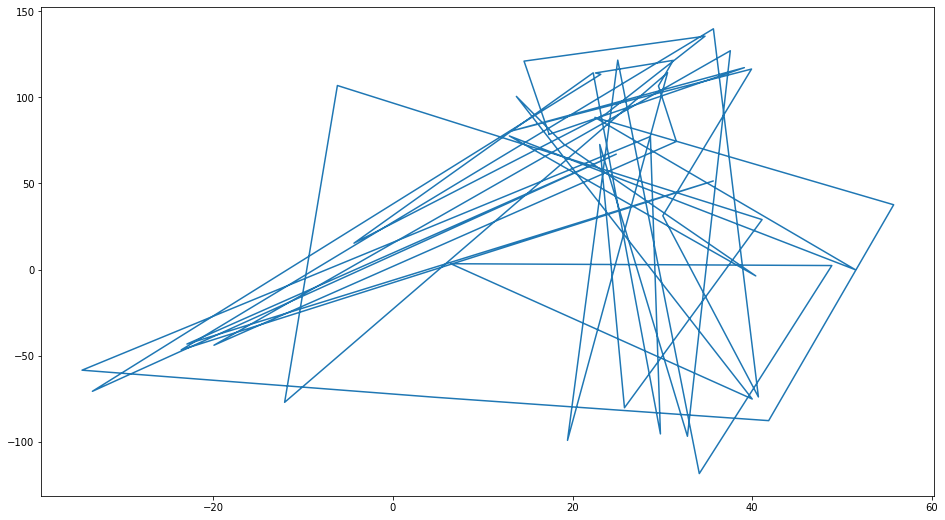

In [26]:
plot_path(random_path, points)

Генетический алгоритм

In [27]:
def selection(population, points):
  new_pop = []
  for p1, p2 in zip(population[::2], population[1::2]):
    f1 = fitness(p1, points)
    f2 = fitness(p2, points)
    if f1 > f2:
      new_pop.append(p1)
    else:
      new_pop.append(p2)
  return new_pop

def crossover(population, target_size, crossover_prob=0.9):
  new_population = []
  for i in range(target_size // 2):
    p1, p2 = random.sample(population, 2)
    if random.random() < crossover_prob:
      new_population.extend(order_crossover(p1, p2))
    else:
      new_population.extend([p1, p2])
  return new_population

def mutation(population, mutation_prob=0.1):
  for p in population:
    if random.random() < mutation_prob:
      mutate_order(p)
  return population

def argmax(a):
  return max(range(len(a)), key=lambda x : a[x])

def search_best(population, pop_fitness):
  return population[argmax(pop_fitness)]

def average_fitness(population, pop_fitness):
  return sum(pop_fitness) / len(population)
  
def run_genetic(points, pop_size=200, n_generations=20):
  random.seed(42)
  avg_trail = []
  best_trail = []
  population = initialize_population(pop_size, n_cities=len(points))
  for i in range(n_generations):
    population = selection(population, points)
    population = crossover(population, target_size=pop_size)
    population = mutation(population)
    pop_fitness = [fitness(p, points) for p in population]
    best_trail.append(max(pop_fitness))
    avg_trail.append(average_fitness(population, pop_fitness))
  X = list(range(n_generations))
  plt.plot(X, avg_trail, label="Average fitness")
  plt.plot(X, best_trail, label="Best fitness")
  plt.legend()
  return search_best(population, pop_fitness)

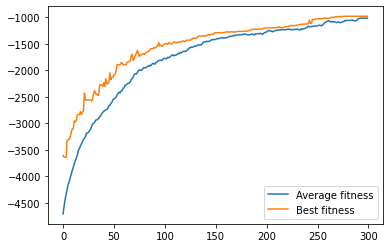

In [28]:
best_path = run_genetic(points, pop_size=400, n_generations=300)

Path cost:  980.5504783828064


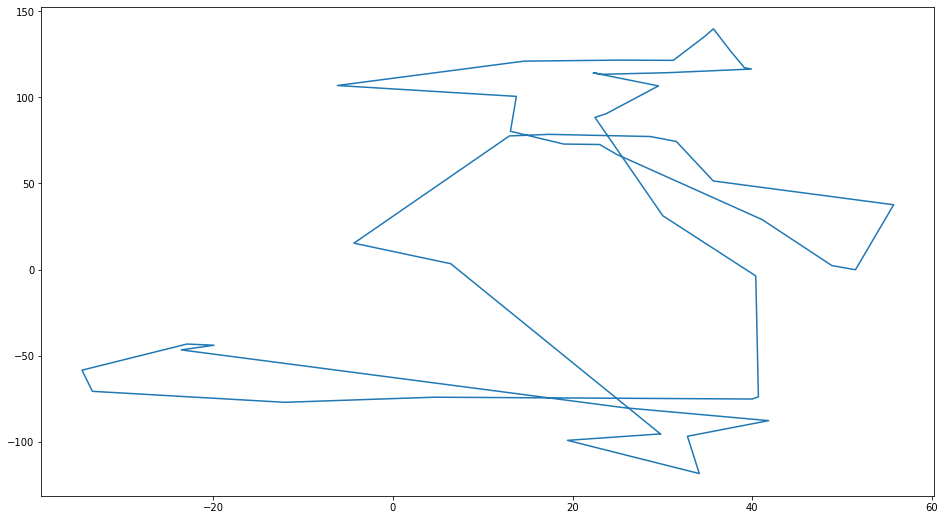

In [29]:
plot_path(best_path, points)

Иммитация Отжига

In [30]:
def probability(candidate_fitness, fitness, T):
    return math.exp(-abs(candidate_fitness - fitness) / T)

def a_fitness(path, points):
    print('Current path', path)
    cur_fit = 0
    for i in range(len(points)):
        distance = math.sqrt((points[path[i % len(points)]][0]
                                  - points[path[(i + 1) % len(points)]][0]) ** 2 +
                                 (points[path[i % len(points)]][1] -
                                  points[path[(i + 1) % len(points)]][1]) ** 2)
        cur_fit += distance
    return cur_fit

In [31]:
# Определим константы
alpha = 0.995
last_T = 1e-8
last_iter = 5000

class SimulatedAnnealing():
    
    def __init__(self, points, temp: int):
        self.points = points
        self.n_cities = len(points)
        self.nodes = [i for i in range(self.n_cities)]

        self.initial_temp = temp
        self.cur_temp = temp

        self.cur_iter = 1
        self.current_path = None
        self.current_fitness = None

        self.best_path = None
        self.best_fitness = float("Inf")
        self.fitness_list = []

        self.run_anneal()
        plot_path(path=self.best_path, points=self.points)
        plt.show()
        plt.plot([i for i in range(len(self.fitness_list))], self.fitness_list, label="Fitness")
        plt.legend()
        plt.show()

    
    def run_anneal(self):

        solution = self.initial_solution()
        self.current_path, self.current_fitness = solution[0], solution[1]

        # повышаем температуру и итерируемся
        while self.cur_temp >= last_T and self.cur_iter < last_iter:
            path = list(self.current_path)
            r_ind = random.randint(2, self.n_cities - 1)
            l_ind = random.randint(0, self.n_cities - r_ind)
            path[l_ind : (l_ind + r_ind)] = reversed(path[l_ind: (l_ind + r_ind)])
            
            self.add_path(path, temp=self.cur_temp)
            self.fitness_list.append(self.current_fitness)

            self.cur_temp *= alpha
            self.cur_iter += 1


    def add_path(self, path, temp):
        # добавляем путь, еcли он 'хороший'
        candidate_fitness = a_fitness(path, points=self.points)
        if candidate_fitness < self.current_fitness:
            self.current_fitness, self.current_path = candidate_fitness, path
            if candidate_fitness < self.best_fitness:
                self.best_fitness, self.best_path = candidate_fitness, path
        else:
            if random.random() < math.exp(-abs(candidate_fitness - self.current_fitness) / temp):
                self.current_fitness = candidate_fitness
                self.current_path = path

    def initial_solution(self):
        cur_node = random.choice(self.nodes) # рандомно выберем вершину
        initial_path = [cur_node]

        # пройдемся по всем вершинам, не заходя в них повторно
        unvisited_nodes = set(self.nodes)
        unvisited_nodes.remove(cur_node)
        while len(unvisited_nodes) != 0:
            next_node = min(unvisited_nodes,
                            key=lambda x: 
                            math.sqrt((self.points[cur_node][0]
                                     - self.points[x][0]) ** 2 +
                                        (self.points[cur_node][1] -
                                        self.points[x][1]) ** 2))  # ищем ближайшего соседа
            cur_node = next_node
            unvisited_nodes.remove(next_node)
            initial_path.append(next_node)

        # если fitness 'хороший', запомним его
        cur_fitness = a_fitness(path=initial_path, points=self.points)
        if cur_fitness < self.best_fitness:
            self.best_fitness = cur_fitness
            self.best_path = initial_path
        self.fitness_list.append(cur_fitness)

        return initial_path, cur_fitness

Current path [9, 7, 41, 36, 34, 3, 48, 11, 38, 5, 27, 12, 18, 17, 19, 25, 46, 21, 28, 45, 13, 4, 10, 43, 26, 29, 40, 44, 1, 24, 42, 47, 2, 8, 37, 23, 30, 32, 35, 6, 31, 39, 15, 33, 20, 14, 0, 16, 22]
Current path [9, 7, 41, 36, 34, 3, 48, 11, 38, 5, 27, 12, 18, 17, 19, 25, 46, 21, 28, 45, 13, 4, 10, 43, 26, 29, 23, 37, 8, 2, 47, 42, 24, 1, 44, 40, 30, 32, 35, 6, 31, 39, 15, 33, 20, 14, 0, 16, 22]
Current path [9, 7, 41, 36, 34, 3, 48, 22, 16, 0, 14, 20, 33, 15, 39, 31, 6, 35, 32, 30, 23, 37, 8, 2, 47, 42, 24, 1, 44, 40, 29, 26, 43, 10, 4, 13, 45, 28, 21, 46, 25, 19, 17, 18, 12, 27, 5, 38, 11]
Current path [9, 7, 41, 36, 21, 46, 25, 19, 17, 18, 12, 27, 5, 38, 11, 48, 3, 34, 28, 45, 13, 4, 10, 43, 26, 29, 40, 44, 1, 24, 42, 47, 2, 8, 37, 23, 30, 32, 35, 6, 31, 39, 15, 33, 20, 14, 0, 16, 22]
Current path [9, 7, 41, 36, 34, 3, 48, 11, 38, 5, 27, 12, 18, 32, 30, 23, 37, 8, 2, 47, 42, 24, 1, 44, 40, 29, 26, 43, 10, 4, 13, 45, 28, 21, 46, 25, 19, 17, 35, 6, 31, 39, 15, 33, 20, 14, 0, 16, 22]


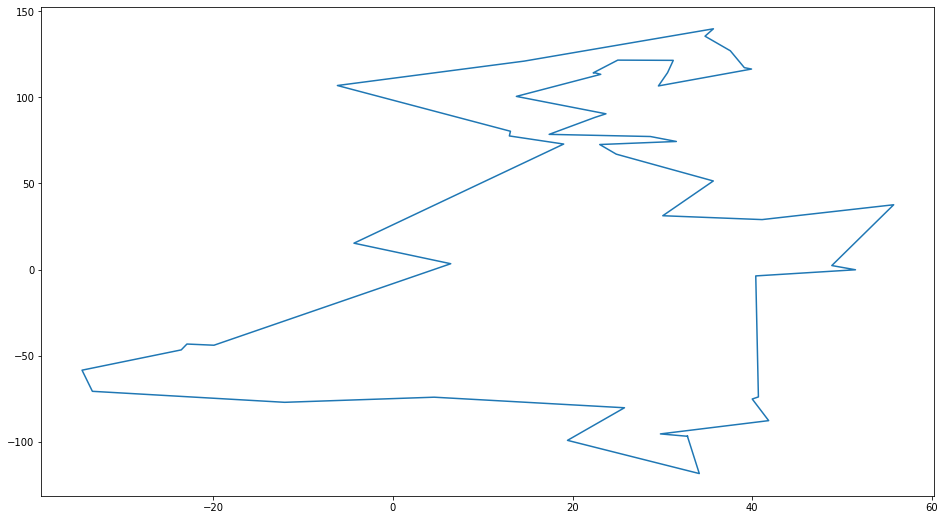

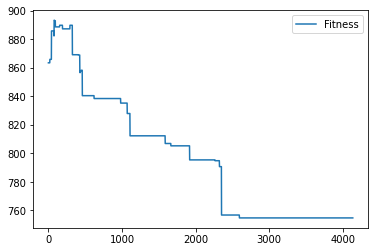

In [32]:
SimulatedAnnealing(points, temp=10)